In [1]:
import os
import numpy as np
import seaborn as sns
from pymbar import BAR
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from glob import glob
import pickle
from simtk.openmm import unit
import bz2
from beryllium import plotting, stats
import pandas as pd
import json
import tqdm
from openmmtools.constants import kB
import networkx as nx
import random
temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [2]:
def form_edge_matrix(g, label, step=None, action=None):
    """
    Extract the labeled property from edges into a matrix

    Parameters
    ----------
    g : nx.Graph
        The graph to extract data from
    label : str
        The label to use for extracting edge properties
    action : str, optional, default=None
        If 'symmetrize', will return a symmetric matrix where A[i,j] = A[j,i]
        If 'antisymmetrize', will return an antisymmetric matrix where A[i,j] = -A[j,i]

    """
    N = len(g.nodes)
    matrix = np.zeros([N,N])
    node_index_map = {j:i for i, j in enumerate(g.nodes)}

    for i, j in g.edges:
        m, n = node_index_map[i],node_index_map[j]        
        matrix[m,n] = g.edges[i,j][label]
        if action == 'symmetrize':
            matrix[n,m] = matrix[m,n]
        elif action == 'antisymmetrize':
            matrix[n,m] = - matrix[m,n]
        elif action is None:
            pass
        else:
            raise Exception(f'action "{action}" unknown.')
    return matrix


def mle(g,factor='f_ij'):
    """
    Compute maximum likelihood estimate of free energies and covariance in their estimates.
    The number 'factor' is the node attribute on which the MLE will be calculated,
    where d'factor' will be used as the standard error of the factor

    We assume the free energy of node 0 is zero.

    Reference : https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00528
    Xu, Huafeng. "Optimal measurement network of pairwise differences." Journal of Chemical Information and Modeling 59.11 (2019): 4720-4728.

    Parameters
    ----------
    g : nx.Graph
        The graph for which an estimate is to be computed
        Each edge must have attributes 'f_ij' and 'df_ij' for the free energy and uncertainty estimate
        Will have 'bayesian_f_ij' and 'bayesian_df_ij' added to each edge
        and 'bayesian_f_i' and 'bayesian_df_i' added to each node.
    factor : string, default = 'f_ij'
        node attribute of nx.Graph that will be used for MLE
    Returns
    -------
    f_i : np.array with shape (n_ligands,)
        f_i[i] is the absolute free energy of ligand i in kT
        f_i[0] = 0

    C : np.array with shape (n_ligands, n_ligands)
        C[i,j] is the covariance of the free energy estimates of i and j

    """
    N = len(g.nodes)
    
    # number of nodes may not be the same as the indices of the nodes
    node_index_map = {j:i for i, j in enumerate(g.nodes)}
    
    f_ij = form_edge_matrix(g, factor, action='antisymmetrize')
    df_ij = form_edge_matrix(g, factor.replace('_','_d'), action='symmetrize')

    # Form F matrix (Eq 4)
    F = np.zeros([N,N])
    for (i,j) in g.edges:
        m, n = node_index_map[i], node_index_map[j]
        F[m,n] = - df_ij[m,n]**(-2)
        F[n,m] = - df_ij[m,n]**(-2)
    for i in g.nodes:
        m = node_index_map[i]
        F[m,m] = - np.sum(F[m,:])

    # Form z vector (Eq 3)
    z = np.zeros([N])
    for (i,j) in g.edges:
        m, n = node_index_map[i], node_index_map[j]
        z[m] += f_ij[m,n] * df_ij[m,n]**(-2)
        z[n] += f_ij[n,m] * df_ij[n,m]**(-2)

    # Compute MLE estimate (Eq 2)
    Finv = np.linalg.pinv(F)
    f_i = - np.matmul(Finv, z) # NOTE: This differs in sign from Eq. 2!
    f_i[:] -= f_i[0]

    # Compute uncertainty
    C = Finv
    return f_i, C

In [3]:
with bz2.BZ2File('../data/work-13420.pkl.bz2', 'r') as infile:
    work = pickle.load(infile)

In [4]:
work.replace([np.inf, -np.inf], np.nan)
work = work.dropna()

def _strip_outliers(w,n_devs=100):
    w = [x for x in w if np.abs(x) < 10**4]
    mean = np.mean(w)
    std = np.std(w)
    good_w = [x for x in w if np.abs(x-mean) < n_devs*std]
    return np.asarray(good_w)

In [5]:
details = {}
jsons = ['2020-07-27.json','2020-07-28.json']
for x in jsons:
    with open(f'/Users/brucemah/bin/covid-moonshot-new/synthetic-enumeration/{x}', 'r') as f:
        new = json.load(f)
        details = {**details, **new}
        print(len(details))

2978
5956


In [6]:
print(set(work['GEN']))

n_gens_run = max([int(x[3:]) for x in set(work['GEN'])])

{'GEN2', 'GEN0', 'GEN1'}


In [7]:
projects = {
    'complex' : 'PROJ13420',
    'solvent' : 'PROJ13421'}

import time
plotting = False

def _get_works(df,run,project,GEN=None):
    works = df[(df['RUN']==run)]
    
    if GEN:
        works = works[works['GEN']==GEN]

    f = works[works['PROJ']==project].forward_work
    r = works[works['PROJ']==project].reverse_work   
    return f, r

n_bootstrap = 1
for d in tqdm.tqdm(details.values()):
    RUN = d['directory']
    if plotting:
        fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    for i, phase in enumerate(projects.keys()):
        if plotting:
            axes[i].set_title(phase)
        
        all_forward = []
        all_reverse = []

        for gen_id in range(0,n_gens_run+1): 
            f_works, r_works = _get_works(work,RUN,projects[phase],GEN=f'GEN{gen_id}')
            f_works = _strip_outliers(f_works)       
            r_works = _strip_outliers(r_works)
            d[f'{phase}_fes_GEN{gen_id}'] = []
            d[f'{phase}_dfes_GEN{gen_id}'] = []

            if len(f_works) > 10 and len(r_works) > 10:
                for _ in range(n_bootstrap):
                    # the f and r's should come from the same switches for bootstrapping
                    f = random.choices(f_works, k=len(f_works))
                    r = random.choices(r_works, k=len(r_works))
                    fe, err = BAR(np.asarray(f), np.asarray(r)) 
                    d[f'{phase}_fes_GEN{gen_id}'].append(fe)
                    d[f'{phase}_dfes_GEN{gen_id}'].append(err)

            all_forward.extend(f_works)
            all_reverse.extend(r_works)

        if len(all_forward) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if len(all_reverse) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if plotting:
            sns.kdeplot(all_forward,shade=True,color='cornflowerblue',ax=axes[i])
            sns.rugplot(all_forward,ax=axes[i],color='cornflowerblue',alpha=0.5,label=f'forward : N={len(f_works)}')
            sns.rugplot(all_forward,ax=axes[i],color='darkblue',label=f'forward (gen0) : N={len(f_works)}')
            sns.rugplot([-x for x in all_reverse],ax=axes[i],color='mediumvioletred',label=f'reverse (gen0) : N={len(r_works)}')
            sns.kdeplot([-x for x in all_reverse],shade=True,color='hotpink',ax=axes[i])
            sns.rugplot([-x for x in all_reverse],ax=axes[i],color='hotpink',alpha=0.5,label=f'reverse : N={len(r_works)}')

        if any([True for x in [all_reverse, all_forward] if len(x) < 20]):
            print(f'Cant calculate {RUN} {phase}')
        else:
            # TODO add bootstrapping here
            d[f'{phase}_fes'] = BAR(np.asarray(all_forward), np.asarray(all_reverse))
              
        
    if plotting:    
        fig.suptitle(f"{RUN}: {d['protein'].split('_')[0]} {d['start']}-{d['end']}", fontsize=16)
        fig.subplots_adjust(top=0.9,wspace=0.15)
        axes[0].legend()
        axes[1].legend()
        plt.show()

  0%|          | 0/5956 [00:00<?, ?it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

  1%|          | 48/5956 [00:20<41:02,  2.40it/s]

Cant calculate RUN1732 complex
Cant calculate RUN1732 solvent


  1%|          | 49/5956 [00:20<40:53,  2.41it/s]

Cant calculate RUN1733 complex
Cant calculate RUN1733 solvent


  1%|          | 51/5956 [00:21<40:36,  2.42it/s]

Cant calculate RUN1735 complex
Cant calculate RUN1735 solvent


  1%|          | 52/5956 [00:21<40:33,  2.43it/s]

Cant calculate RUN1736 complex
Cant calculate RUN1736 solvent


  1%|          | 55/5956 [00:23<40:27,  2.43it/s]

Cant calculate RUN1739 complex
Cant calculate RUN1739 solvent


  3%|▎         | 170/5956 [01:11<40:31,  2.38it/s]

Cant calculate RUN1854 complex
Cant calculate RUN1854 solvent


  4%|▍         | 236/5956 [01:39<39:46,  2.40it/s]

Cant calculate RUN1920 complex
Cant calculate RUN1920 solvent


  4%|▍         | 237/5956 [01:39<39:43,  2.40it/s]

Cant calculate RUN1921 complex
Cant calculate RUN1921 solvent


  4%|▍         | 238/5956 [01:40<39:42,  2.40it/s]

Cant calculate RUN1922 complex
Cant calculate RUN1922 solvent


  4%|▍         | 239/5956 [01:40<39:47,  2.39it/s]

Cant calculate RUN1923 complex
Cant calculate RUN1923 solvent


  4%|▍         | 240/5956 [01:41<39:30,  2.41it/s]

Cant calculate RUN1924 complex
Cant calculate RUN1924 solvent


  4%|▍         | 242/5956 [01:42<39:28,  2.41it/s]

Cant calculate RUN1926 complex
Cant calculate RUN1926 solvent


  5%|▌         | 323/5956 [02:16<38:46,  2.42it/s]

Cant calculate RUN2007 complex
Cant calculate RUN2007 solvent


  6%|▌         | 336/5956 [02:21<39:16,  2.39it/s]

Cant calculate RUN2020 complex
Cant calculate RUN2020 solvent


  6%|▌         | 369/5956 [02:35<38:40,  2.41it/s]

Cant calculate RUN2053 complex
Cant calculate RUN2053 solvent


  6%|▌         | 370/5956 [02:35<38:31,  2.42it/s]

Cant calculate RUN2054 complex
Cant calculate RUN2054 solvent


  6%|▌         | 371/5956 [02:36<38:20,  2.43it/s]

Cant calculate RUN2055 complex
Cant calculate RUN2055 solvent


  6%|▌         | 372/5956 [02:36<38:14,  2.43it/s]

Cant calculate RUN2056 complex
Cant calculate RUN2056 solvent


  6%|▋         | 373/5956 [02:37<38:20,  2.43it/s]

Cant calculate RUN2057 complex
Cant calculate RUN2057 solvent


  6%|▋         | 374/5956 [02:37<38:28,  2.42it/s]

Cant calculate RUN2058 complex
Cant calculate RUN2058 solvent


  6%|▋         | 375/5956 [02:38<38:22,  2.42it/s]

Cant calculate RUN2059 complex
Cant calculate RUN2059 solvent


  6%|▋         | 376/5956 [02:38<38:12,  2.43it/s]

Cant calculate RUN2060 complex
Cant calculate RUN2060 solvent


  7%|▋         | 392/5956 [02:45<38:51,  2.39it/s]

Cant calculate RUN2076 complex
Cant calculate RUN2076 solvent


  7%|▋         | 426/5956 [02:59<38:42,  2.38it/s]

Cant calculate RUN2110 complex
Cant calculate RUN2110 solvent


  7%|▋         | 427/5956 [02:59<38:37,  2.39it/s]

Cant calculate RUN2111 complex
Cant calculate RUN2111 solvent


  8%|▊         | 490/5956 [03:26<38:05,  2.39it/s]

Cant calculate RUN2174 complex
Cant calculate RUN2174 solvent


  8%|▊         | 493/5956 [03:27<37:42,  2.41it/s]

Cant calculate RUN2177 complex
Cant calculate RUN2177 solvent


  8%|▊         | 494/5956 [03:28<37:33,  2.42it/s]

Cant calculate RUN2178 complex
Cant calculate RUN2178 solvent


  8%|▊         | 495/5956 [03:28<37:26,  2.43it/s]

Cant calculate RUN2179 complex
Cant calculate RUN2179 solvent


  8%|▊         | 496/5956 [03:28<37:19,  2.44it/s]

Cant calculate RUN2180 complex
Cant calculate RUN2180 solvent


  8%|▊         | 497/5956 [03:29<37:23,  2.43it/s]

Cant calculate RUN2181 complex
Cant calculate RUN2181 solvent


  8%|▊         | 498/5956 [03:29<37:22,  2.43it/s]

Cant calculate RUN2182 complex
Cant calculate RUN2182 solvent


  8%|▊         | 499/5956 [03:30<37:43,  2.41it/s]

Cant calculate RUN2183 complex
Cant calculate RUN2183 solvent


  8%|▊         | 500/5956 [03:30<37:44,  2.41it/s]

Cant calculate RUN2184 complex
Cant calculate RUN2184 solvent


  9%|▉         | 559/5956 [03:55<37:11,  2.42it/s]

Cant calculate RUN2243 complex
Cant calculate RUN2243 solvent


  9%|▉         | 560/5956 [03:55<36:57,  2.43it/s]

Cant calculate RUN2244 complex
Cant calculate RUN2244 solvent


 10%|▉         | 574/5956 [04:01<37:52,  2.37it/s]

Cant calculate RUN2258 complex
Cant calculate RUN2258 solvent


 10%|▉         | 576/5956 [04:02<37:30,  2.39it/s]

Cant calculate RUN2260 complex
Cant calculate RUN2260 solvent


 10%|▉         | 585/5956 [04:06<37:09,  2.41it/s]

Cant calculate RUN2269 complex
Cant calculate RUN2269 solvent


 10%|▉         | 586/5956 [04:06<36:59,  2.42it/s]

Cant calculate RUN2270 complex
Cant calculate RUN2270 solvent


 10%|▉         | 587/5956 [04:07<36:57,  2.42it/s]

Cant calculate RUN2271 complex
Cant calculate RUN2271 solvent


 10%|▉         | 588/5956 [04:07<36:52,  2.43it/s]

Cant calculate RUN2272 complex
Cant calculate RUN2272 solvent


 10%|▉         | 589/5956 [04:08<36:54,  2.42it/s]

Cant calculate RUN2273 complex
Cant calculate RUN2273 solvent


 10%|▉         | 590/5956 [04:08<36:51,  2.43it/s]

Cant calculate RUN2274 complex
Cant calculate RUN2274 solvent


 10%|▉         | 591/5956 [04:08<36:47,  2.43it/s]

Cant calculate RUN2275 complex
Cant calculate RUN2275 solvent


 10%|▉         | 592/5956 [04:09<36:48,  2.43it/s]

Cant calculate RUN2276 complex
Cant calculate RUN2276 solvent


 10%|█         | 606/5956 [04:15<36:57,  2.41it/s]

Cant calculate RUN2290 complex
Cant calculate RUN2290 solvent


 11%|█         | 643/5956 [04:30<36:59,  2.39it/s]

Cant calculate RUN2327 complex
Cant calculate RUN2327 solvent


 11%|█         | 644/5956 [04:31<36:50,  2.40it/s]

Cant calculate RUN2328 complex
Cant calculate RUN2328 solvent


 11%|█         | 654/5956 [04:35<37:20,  2.37it/s]

Cant calculate RUN2338 complex
Cant calculate RUN2338 solvent


 11%|█         | 655/5956 [04:35<37:04,  2.38it/s]

Cant calculate RUN2339 complex
Cant calculate RUN2339 solvent


 11%|█         | 656/5956 [04:36<36:47,  2.40it/s]

Cant calculate RUN2340 complex
Cant calculate RUN2340 solvent


 11%|█         | 657/5956 [04:36<36:50,  2.40it/s]

Cant calculate RUN2341 complex
Cant calculate RUN2341 solvent


 11%|█         | 658/5956 [04:36<36:37,  2.41it/s]

Cant calculate RUN2342 complex
Cant calculate RUN2342 solvent


 12%|█▏        | 725/5956 [05:05<36:06,  2.41it/s]

Cant calculate RUN2409 complex
Cant calculate RUN2409 solvent


 13%|█▎        | 793/5956 [05:34<36:08,  2.38it/s]

Cant calculate RUN2477 complex
Cant calculate RUN2477 solvent


 13%|█▎        | 794/5956 [05:34<35:54,  2.40it/s]

Cant calculate RUN2478 complex
Cant calculate RUN2478 solvent


 14%|█▎        | 818/5956 [05:44<35:57,  2.38it/s]

Cant calculate RUN2502 complex
Cant calculate RUN2502 solvent


 14%|█▍        | 820/5956 [05:45<35:46,  2.39it/s]

Cant calculate RUN2504 complex
Cant calculate RUN2504 solvent


 14%|█▍        | 821/5956 [05:46<35:38,  2.40it/s]

Cant calculate RUN2505 complex
Cant calculate RUN2505 solvent


 14%|█▍        | 828/5956 [05:49<36:57,  2.31it/s]

Cant calculate RUN2512 complex
Cant calculate RUN2512 solvent


 14%|█▍        | 832/5956 [05:50<36:02,  2.37it/s]

Cant calculate RUN2516 complex
Cant calculate RUN2516 solvent


 14%|█▍        | 860/5956 [06:02<35:22,  2.40it/s]

Cant calculate RUN2544 complex
Cant calculate RUN2544 solvent


 14%|█▍        | 861/5956 [06:02<35:11,  2.41it/s]

Cant calculate RUN2545 complex
Cant calculate RUN2545 solvent


 14%|█▍        | 862/5956 [06:03<35:03,  2.42it/s]

Cant calculate RUN2546 complex
Cant calculate RUN2546 solvent


 14%|█▍        | 863/5956 [06:03<34:58,  2.43it/s]

Cant calculate RUN2547 complex
Cant calculate RUN2547 solvent


 15%|█▍        | 865/5956 [06:04<35:15,  2.41it/s]

Cant calculate RUN2549 complex
Cant calculate RUN2549 solvent


 15%|█▍        | 869/5956 [06:06<35:03,  2.42it/s]

Cant calculate RUN2553 complex
Cant calculate RUN2553 solvent


 15%|█▍        | 870/5956 [06:06<34:56,  2.43it/s]

Cant calculate RUN2554 complex
Cant calculate RUN2554 solvent


 15%|█▍        | 873/5956 [06:07<35:06,  2.41it/s]

Cant calculate RUN2557 complex
Cant calculate RUN2557 solvent


 15%|█▍        | 874/5956 [06:08<34:56,  2.42it/s]

Cant calculate RUN2558 complex
Cant calculate RUN2558 solvent


 15%|█▍        | 877/5956 [06:09<35:00,  2.42it/s]

Cant calculate RUN2561 complex
Cant calculate RUN2561 solvent


 16%|█▌        | 960/5956 [06:44<34:53,  2.39it/s]

Cant calculate RUN2644 complex
Cant calculate RUN2644 solvent


 16%|█▌        | 963/5956 [06:46<34:42,  2.40it/s]

Cant calculate RUN2647 complex
Cant calculate RUN2647 solvent


 16%|█▌        | 966/5956 [06:47<35:16,  2.36it/s]

Cant calculate RUN2650 solvent


 16%|█▋        | 977/5956 [06:52<35:25,  2.34it/s]

Cant calculate RUN2661 complex
Cant calculate RUN2661 solvent


 17%|█▋        | 1019/5956 [07:10<34:39,  2.37it/s]

Cant calculate RUN2703 complex
Cant calculate RUN2703 solvent


 17%|█▋        | 1027/5956 [07:13<34:28,  2.38it/s]

Cant calculate RUN2711 complex
Cant calculate RUN2711 solvent


 17%|█▋        | 1028/5956 [07:14<34:40,  2.37it/s]

Cant calculate RUN2712 complex
Cant calculate RUN2712 solvent


 17%|█▋        | 1030/5956 [07:14<34:29,  2.38it/s]

Cant calculate RUN2714 complex
Cant calculate RUN2714 solvent


 17%|█▋        | 1033/5956 [07:16<34:54,  2.35it/s]

Cant calculate RUN2717 complex
Cant calculate RUN2717 solvent


 17%|█▋        | 1035/5956 [07:17<34:42,  2.36it/s]

Cant calculate RUN2719 complex
Cant calculate RUN2719 solvent


 18%|█▊        | 1051/5956 [07:23<35:36,  2.30it/s]

Cant calculate RUN2735 solvent


 18%|█▊        | 1058/5956 [07:26<34:27,  2.37it/s]

Cant calculate RUN2742 complex
Cant calculate RUN2742 solvent


 18%|█▊        | 1059/5956 [07:27<34:10,  2.39it/s]

Cant calculate RUN2743 complex
Cant calculate RUN2743 solvent


 18%|█▊        | 1065/5956 [07:29<34:26,  2.37it/s]

Cant calculate RUN2749 complex
Cant calculate RUN2749 solvent


 18%|█▊        | 1068/5956 [07:31<34:20,  2.37it/s]

Cant calculate RUN2752 complex
Cant calculate RUN2752 solvent


 18%|█▊        | 1070/5956 [07:31<34:26,  2.36it/s]

Cant calculate RUN2754 complex
Cant calculate RUN2754 solvent


 18%|█▊        | 1071/5956 [07:32<34:19,  2.37it/s]

Cant calculate RUN2755 complex
Cant calculate RUN2755 solvent


 18%|█▊        | 1072/5956 [07:32<34:18,  2.37it/s]

Cant calculate RUN2756 complex
Cant calculate RUN2756 solvent


 18%|█▊        | 1073/5956 [07:33<34:02,  2.39it/s]

Cant calculate RUN2757 complex
Cant calculate RUN2757 solvent


 18%|█▊        | 1074/5956 [07:33<33:57,  2.40it/s]

Cant calculate RUN2758 complex
Cant calculate RUN2758 solvent


 18%|█▊        | 1075/5956 [07:34<33:55,  2.40it/s]

Cant calculate RUN2759 complex
Cant calculate RUN2759 solvent


 18%|█▊        | 1080/5956 [07:36<34:03,  2.39it/s]

Cant calculate RUN2764 complex
Cant calculate RUN2764 solvent


 18%|█▊        | 1081/5956 [07:36<33:53,  2.40it/s]

Cant calculate RUN2765 complex
Cant calculate RUN2765 solvent


 19%|█▉        | 1124/5956 [07:54<34:01,  2.37it/s]

Cant calculate RUN2808 complex
Cant calculate RUN2808 solvent


 19%|█▉        | 1130/5956 [07:57<33:53,  2.37it/s]

Cant calculate RUN2814 complex
Cant calculate RUN2814 solvent


 20%|██        | 1192/5956 [08:23<33:21,  2.38it/s]

Cant calculate RUN2876 complex
Cant calculate RUN2876 solvent


 21%|██        | 1223/5956 [08:36<33:00,  2.39it/s]

Cant calculate RUN2907 complex
Cant calculate RUN2907 solvent


 21%|██        | 1225/5956 [08:37<33:13,  2.37it/s]

Cant calculate RUN2909 complex
Cant calculate RUN2909 solvent


 21%|██        | 1254/5956 [08:49<32:56,  2.38it/s]

Cant calculate RUN2938 complex
Cant calculate RUN2938 solvent


 21%|██        | 1255/5956 [08:50<32:40,  2.40it/s]

Cant calculate RUN2939 complex
Cant calculate RUN2939 solvent


 21%|██        | 1256/5956 [08:50<32:27,  2.41it/s]

Cant calculate RUN2940 complex
Cant calculate RUN2940 solvent


 21%|██        | 1264/5956 [08:54<32:37,  2.40it/s]

Cant calculate RUN2948 complex
Cant calculate RUN2948 solvent


 22%|██▏       | 1307/5956 [09:12<32:54,  2.35it/s]

Cant calculate RUN2991 complex
Cant calculate RUN2991 solvent


 22%|██▏       | 1314/5956 [09:15<32:34,  2.37it/s]

Cant calculate RUN2998 solvent


 23%|██▎       | 1375/5956 [09:41<31:49,  2.40it/s]

Cant calculate RUN3059 complex
Cant calculate RUN3059 solvent


 23%|██▎       | 1378/5956 [09:42<31:41,  2.41it/s]

Cant calculate RUN3062 complex
Cant calculate RUN3062 solvent


 23%|██▎       | 1382/5956 [09:44<31:43,  2.40it/s]

Cant calculate RUN3066 complex
Cant calculate RUN3066 solvent


 26%|██▋       | 1564/5956 [11:01<30:47,  2.38it/s]

Cant calculate RUN3248 complex
Cant calculate RUN3248 solvent


 26%|██▋       | 1565/5956 [11:01<30:31,  2.40it/s]

Cant calculate RUN3249 complex
Cant calculate RUN3249 solvent


 26%|██▋       | 1566/5956 [11:01<30:20,  2.41it/s]

Cant calculate RUN3250 complex
Cant calculate RUN3250 solvent


 26%|██▋       | 1569/5956 [11:03<30:32,  2.39it/s]

Cant calculate RUN3253 complex
Cant calculate RUN3253 solvent


 26%|██▋       | 1574/5956 [11:05<31:09,  2.34it/s]

Cant calculate RUN3258 solvent


 28%|██▊       | 1650/5956 [11:37<30:15,  2.37it/s]

Cant calculate RUN3334 complex
Cant calculate RUN3334 solvent


 28%|██▊       | 1696/5956 [11:56<30:08,  2.36it/s]

Cant calculate RUN3380 complex
Cant calculate RUN3380 solvent


 28%|██▊       | 1697/5956 [11:57<29:49,  2.38it/s]

Cant calculate RUN3381 complex
Cant calculate RUN3381 solvent


 29%|██▊       | 1698/5956 [11:57<29:35,  2.40it/s]

Cant calculate RUN3382 complex
Cant calculate RUN3382 solvent


 29%|██▊       | 1699/5956 [11:58<29:27,  2.41it/s]

Cant calculate RUN3383 complex
Cant calculate RUN3383 solvent


 29%|██▊       | 1700/5956 [11:58<29:19,  2.42it/s]

Cant calculate RUN3384 complex
Cant calculate RUN3384 solvent


 29%|██▊       | 1701/5956 [11:58<29:17,  2.42it/s]

Cant calculate RUN3385 complex
Cant calculate RUN3385 solvent


 29%|██▊       | 1702/5956 [11:59<29:11,  2.43it/s]

Cant calculate RUN3386 complex
Cant calculate RUN3386 solvent


 29%|██▊       | 1703/5956 [11:59<29:08,  2.43it/s]

Cant calculate RUN3387 complex
Cant calculate RUN3387 solvent


 29%|██▉       | 1723/5956 [12:08<29:27,  2.39it/s]

Cant calculate RUN3407 complex
Cant calculate RUN3407 solvent


 29%|██▉       | 1725/5956 [12:08<29:20,  2.40it/s]

Cant calculate RUN3409 complex
Cant calculate RUN3409 solvent


 29%|██▉       | 1751/5956 [12:19<29:20,  2.39it/s]

Cant calculate RUN3435 complex
Cant calculate RUN3435 solvent


 29%|██▉       | 1752/5956 [12:20<29:15,  2.39it/s]

Cant calculate RUN3436 complex
Cant calculate RUN3436 solvent


 29%|██▉       | 1753/5956 [12:20<29:04,  2.41it/s]

Cant calculate RUN3437 complex
Cant calculate RUN3437 solvent


 30%|██▉       | 1780/5956 [12:32<29:05,  2.39it/s]

Cant calculate RUN3464 complex
Cant calculate RUN3464 solvent


 31%|███       | 1817/5956 [12:47<29:01,  2.38it/s]

Cant calculate RUN3501 complex
Cant calculate RUN3501 solvent


 31%|███       | 1820/5956 [12:48<28:54,  2.38it/s]

Cant calculate RUN3504 complex
Cant calculate RUN3504 solvent


 31%|███       | 1821/5956 [12:49<28:53,  2.39it/s]

Cant calculate RUN3505 complex
Cant calculate RUN3505 solvent


 31%|███       | 1822/5956 [12:49<28:42,  2.40it/s]

Cant calculate RUN3506 complex
Cant calculate RUN3506 solvent


 31%|███       | 1823/5956 [12:50<28:34,  2.41it/s]

Cant calculate RUN3507 complex
Cant calculate RUN3507 solvent


 31%|███       | 1824/5956 [12:50<28:25,  2.42it/s]

Cant calculate RUN3508 complex
Cant calculate RUN3508 solvent


 31%|███       | 1825/5956 [12:51<28:21,  2.43it/s]

Cant calculate RUN3509 complex
Cant calculate RUN3509 solvent


 31%|███       | 1826/5956 [12:51<28:20,  2.43it/s]

Cant calculate RUN3510 complex
Cant calculate RUN3510 solvent


 31%|███       | 1827/5956 [12:51<28:31,  2.41it/s]

Cant calculate RUN3511 complex
Cant calculate RUN3511 solvent


 31%|███       | 1831/5956 [12:53<28:36,  2.40it/s]

Cant calculate RUN3515 complex
Cant calculate RUN3515 solvent


 31%|███       | 1832/5956 [12:53<28:36,  2.40it/s]

Cant calculate RUN3516 complex
Cant calculate RUN3516 solvent


 32%|███▏      | 1886/5956 [13:16<28:35,  2.37it/s]

Cant calculate RUN3570 complex
Cant calculate RUN3570 solvent


 32%|███▏      | 1887/5956 [13:17<28:30,  2.38it/s]

Cant calculate RUN3571 complex
Cant calculate RUN3571 solvent


 32%|███▏      | 1902/5956 [13:23<28:09,  2.40it/s]

Cant calculate RUN3586 complex
Cant calculate RUN3586 solvent


 32%|███▏      | 1912/5956 [13:27<28:12,  2.39it/s]

Cant calculate RUN3596 complex
Cant calculate RUN3596 solvent


 32%|███▏      | 1913/5956 [13:28<28:03,  2.40it/s]

Cant calculate RUN3597 complex
Cant calculate RUN3597 solvent


 32%|███▏      | 1914/5956 [13:28<27:59,  2.41it/s]

Cant calculate RUN3598 complex
Cant calculate RUN3598 solvent


 32%|███▏      | 1915/5956 [13:29<27:52,  2.42it/s]

Cant calculate RUN3599 complex
Cant calculate RUN3599 solvent


 32%|███▏      | 1916/5956 [13:29<27:50,  2.42it/s]

Cant calculate RUN3600 complex
Cant calculate RUN3600 solvent


 32%|███▏      | 1917/5956 [13:29<27:46,  2.42it/s]

Cant calculate RUN3601 complex
Cant calculate RUN3601 solvent


 32%|███▏      | 1918/5956 [13:30<27:44,  2.43it/s]

Cant calculate RUN3602 complex
Cant calculate RUN3602 solvent


 32%|███▏      | 1919/5956 [13:30<27:44,  2.43it/s]

Cant calculate RUN3603 complex
Cant calculate RUN3603 solvent


 32%|███▏      | 1933/5956 [13:36<28:07,  2.38it/s]

Cant calculate RUN3617 complex
Cant calculate RUN3617 solvent


 33%|███▎      | 1972/5956 [13:53<27:38,  2.40it/s]

Cant calculate RUN3656 complex
Cant calculate RUN3656 solvent


 33%|███▎      | 1981/5956 [13:56<28:14,  2.35it/s]

Cant calculate RUN3665 complex
Cant calculate RUN3665 solvent


 33%|███▎      | 1982/5956 [13:57<27:57,  2.37it/s]

Cant calculate RUN3666 complex
Cant calculate RUN3666 solvent


 33%|███▎      | 1984/5956 [13:58<28:01,  2.36it/s]

Cant calculate RUN3668 complex
Cant calculate RUN3668 solvent


 34%|███▍      | 2011/5956 [14:09<27:49,  2.36it/s]

Cant calculate RUN3695 complex
Cant calculate RUN3695 solvent


 34%|███▍      | 2022/5956 [14:14<28:05,  2.33it/s]

Cant calculate RUN3706 complex
Cant calculate RUN3706 solvent


 34%|███▍      | 2054/5956 [14:28<27:17,  2.38it/s]

Cant calculate RUN3738 complex
Cant calculate RUN3738 solvent


 35%|███▌      | 2088/5956 [14:42<27:05,  2.38it/s]

Cant calculate RUN3772 complex
Cant calculate RUN3772 solvent


 35%|███▌      | 2092/5956 [14:44<26:50,  2.40it/s]

Cant calculate RUN3776 complex
Cant calculate RUN3776 solvent


 36%|███▌      | 2144/5956 [15:06<26:50,  2.37it/s]

Cant calculate RUN3828 complex
Cant calculate RUN3828 solvent


 36%|███▌      | 2147/5956 [15:07<26:47,  2.37it/s]

Cant calculate RUN3831 complex
Cant calculate RUN3831 solvent


 36%|███▌      | 2148/5956 [15:07<26:38,  2.38it/s]

Cant calculate RUN3832 complex
Cant calculate RUN3832 solvent


 36%|███▌      | 2151/5956 [15:09<26:52,  2.36it/s]

Cant calculate RUN3835 complex
Cant calculate RUN3835 solvent


 36%|███▌      | 2152/5956 [15:09<26:41,  2.38it/s]

Cant calculate RUN3836 complex
Cant calculate RUN3836 solvent


 36%|███▌      | 2153/5956 [15:09<26:36,  2.38it/s]

Cant calculate RUN3837 complex
Cant calculate RUN3837 solvent


 36%|███▌      | 2156/5956 [15:11<26:34,  2.38it/s]

Cant calculate RUN3840 complex
Cant calculate RUN3840 solvent


 36%|███▌      | 2157/5956 [15:11<26:31,  2.39it/s]

Cant calculate RUN3841 complex
Cant calculate RUN3841 solvent


 36%|███▌      | 2158/5956 [15:11<26:37,  2.38it/s]

Cant calculate RUN3842 complex
Cant calculate RUN3842 solvent


 37%|███▋      | 2186/5956 [15:23<25:43,  2.44it/s]

Cant calculate RUN3870 complex
Cant calculate RUN3870 solvent


 37%|███▋      | 2187/5956 [15:24<25:40,  2.45it/s]

Cant calculate RUN3871 complex
Cant calculate RUN3871 solvent


 37%|███▋      | 2188/5956 [15:24<25:33,  2.46it/s]

Cant calculate RUN3872 complex
Cant calculate RUN3872 solvent


 37%|███▋      | 2191/5956 [15:25<25:33,  2.46it/s]

Cant calculate RUN3875 complex
Cant calculate RUN3875 solvent


 37%|███▋      | 2196/5956 [15:27<26:11,  2.39it/s]

Cant calculate RUN3880 complex
Cant calculate RUN3880 solvent


 37%|███▋      | 2197/5956 [15:28<26:06,  2.40it/s]

Cant calculate RUN3881 complex
Cant calculate RUN3881 solvent


 37%|███▋      | 2198/5956 [15:28<26:02,  2.40it/s]

Cant calculate RUN3882 complex
Cant calculate RUN3882 solvent


 37%|███▋      | 2199/5956 [15:29<25:55,  2.41it/s]

Cant calculate RUN3883 complex
Cant calculate RUN3883 solvent


 37%|███▋      | 2201/5956 [15:29<26:17,  2.38it/s]

Cant calculate RUN3885 complex
Cant calculate RUN3885 solvent


 39%|███▊      | 2304/5956 [16:13<25:35,  2.38it/s]

Cant calculate RUN3988 complex
Cant calculate RUN3988 solvent


 39%|███▉      | 2346/5956 [16:31<25:11,  2.39it/s]

Cant calculate RUN4030 complex
Cant calculate RUN4030 solvent


 40%|███▉      | 2354/5956 [16:34<25:38,  2.34it/s]

Cant calculate RUN4038 complex
Cant calculate RUN4038 solvent


 40%|███▉      | 2356/5956 [16:35<25:22,  2.36it/s]

Cant calculate RUN4040 complex
Cant calculate RUN4040 solvent


 40%|███▉      | 2357/5956 [16:35<25:08,  2.39it/s]

Cant calculate RUN4041 complex
Cant calculate RUN4041 solvent


 40%|███▉      | 2358/5956 [16:36<24:58,  2.40it/s]

Cant calculate RUN4042 complex
Cant calculate RUN4042 solvent


 40%|███▉      | 2360/5956 [16:37<24:57,  2.40it/s]

Cant calculate RUN4044 complex
Cant calculate RUN4044 solvent


 40%|███▉      | 2362/5956 [16:37<25:02,  2.39it/s]

Cant calculate RUN4046 complex
Cant calculate RUN4046 solvent


 40%|████      | 2384/5956 [16:47<25:01,  2.38it/s]

Cant calculate RUN4068 complex
Cant calculate RUN4068 solvent


 40%|████      | 2385/5956 [16:47<24:52,  2.39it/s]

Cant calculate RUN4069 complex
Cant calculate RUN4069 solvent


 40%|████      | 2386/5956 [16:48<24:42,  2.41it/s]

Cant calculate RUN4070 complex
Cant calculate RUN4070 solvent


 40%|████      | 2392/5956 [16:50<25:06,  2.37it/s]

Cant calculate RUN4076 complex
Cant calculate RUN4076 solvent


 40%|████      | 2395/5956 [16:51<25:01,  2.37it/s]

Cant calculate RUN4079 complex
Cant calculate RUN4079 solvent


 40%|████      | 2397/5956 [16:52<25:13,  2.35it/s]

Cant calculate RUN4081 complex
Cant calculate RUN4081 solvent


 40%|████      | 2399/5956 [16:53<25:02,  2.37it/s]

Cant calculate RUN4083 complex
Cant calculate RUN4083 solvent


 40%|████      | 2400/5956 [16:54<24:56,  2.38it/s]

Cant calculate RUN4084 complex
Cant calculate RUN4084 solvent


 40%|████      | 2401/5956 [16:54<24:58,  2.37it/s]

Cant calculate RUN4085 complex
Cant calculate RUN4085 solvent


 40%|████      | 2402/5956 [16:54<24:49,  2.39it/s]

Cant calculate RUN4086 complex
Cant calculate RUN4086 solvent


 41%|████      | 2444/5956 [17:12<24:25,  2.40it/s]

Cant calculate RUN4128 complex
Cant calculate RUN4128 solvent


 41%|████      | 2451/5956 [17:15<24:31,  2.38it/s]

Cant calculate RUN4135 complex
Cant calculate RUN4135 solvent


 41%|████▏     | 2457/5956 [17:18<24:19,  2.40it/s]

Cant calculate RUN4141 complex
Cant calculate RUN4141 solvent


 42%|████▏     | 2514/5956 [17:41<24:01,  2.39it/s]

Cant calculate RUN4198 complex
Cant calculate RUN4198 solvent


 42%|████▏     | 2515/5956 [17:42<23:49,  2.41it/s]

Cant calculate RUN4199 complex
Cant calculate RUN4199 solvent


 42%|████▏     | 2519/5956 [17:44<23:55,  2.40it/s]

Cant calculate RUN4203 complex
Cant calculate RUN4203 solvent


 43%|████▎     | 2549/5956 [17:56<23:42,  2.40it/s]

Cant calculate RUN4233 complex
Cant calculate RUN4233 solvent


 43%|████▎     | 2551/5956 [17:57<23:34,  2.41it/s]

Cant calculate RUN4235 complex
Cant calculate RUN4235 solvent


 43%|████▎     | 2552/5956 [17:57<23:27,  2.42it/s]

Cant calculate RUN4236 complex
Cant calculate RUN4236 solvent


 43%|████▎     | 2581/5956 [18:10<23:19,  2.41it/s]

Cant calculate RUN4265 complex
Cant calculate RUN4265 solvent


 43%|████▎     | 2582/5956 [18:10<23:13,  2.42it/s]

Cant calculate RUN4266 complex
Cant calculate RUN4266 solvent


 43%|████▎     | 2583/5956 [18:10<23:10,  2.43it/s]

Cant calculate RUN4267 complex
Cant calculate RUN4267 solvent


 43%|████▎     | 2584/5956 [18:11<23:15,  2.42it/s]

Cant calculate RUN4268 complex
Cant calculate RUN4268 solvent


 44%|████▎     | 2591/5956 [18:14<23:21,  2.40it/s]

Cant calculate RUN4275 complex
Cant calculate RUN4275 solvent


 44%|████▍     | 2616/5956 [18:24<23:11,  2.40it/s]

Cant calculate RUN4300 complex
Cant calculate RUN4300 solvent


 46%|████▋     | 2756/5956 [19:23<22:17,  2.39it/s]

Cant calculate RUN4440 complex
Cant calculate RUN4440 solvent


 46%|████▋     | 2757/5956 [19:24<22:08,  2.41it/s]

Cant calculate RUN4441 complex
Cant calculate RUN4441 solvent


 47%|████▋     | 2801/5956 [19:42<21:49,  2.41it/s]

Cant calculate RUN4485 complex
Cant calculate RUN4485 solvent


 47%|████▋     | 2802/5956 [19:42<21:44,  2.42it/s]

Cant calculate RUN4486 complex
Cant calculate RUN4486 solvent


 47%|████▋     | 2803/5956 [19:43<21:40,  2.42it/s]

Cant calculate RUN4487 complex
Cant calculate RUN4487 solvent


 48%|████▊     | 2884/5956 [20:17<21:18,  2.40it/s]

Cant calculate RUN4568 complex
Cant calculate RUN4568 solvent


 49%|████▉     | 2918/5956 [20:31<21:13,  2.38it/s]

Cant calculate RUN4602 complex
Cant calculate RUN4602 solvent


 49%|████▉     | 2919/5956 [20:32<21:05,  2.40it/s]

Cant calculate RUN4603 complex
Cant calculate RUN4603 solvent


 50%|████▉     | 2962/5956 [20:50<20:51,  2.39it/s]

Cant calculate RUN4646 complex
Cant calculate RUN4646 solvent


 50%|████▉     | 2963/5956 [20:50<20:42,  2.41it/s]

Cant calculate RUN4647 complex
Cant calculate RUN4647 solvent


 50%|████▉     | 2964/5956 [20:51<20:36,  2.42it/s]

Cant calculate RUN4648 complex
Cant calculate RUN4648 solvent


 50%|████▉     | 2965/5956 [20:51<20:33,  2.43it/s]

Cant calculate RUN4649 complex
Cant calculate RUN4649 solvent


 51%|█████     | 3026/5956 [21:17<20:24,  2.39it/s]

Cant calculate RUN4710 complex
Cant calculate RUN4710 solvent


 51%|█████     | 3027/5956 [21:17<20:16,  2.41it/s]

Cant calculate RUN4711 complex
Cant calculate RUN4711 solvent


 51%|█████     | 3028/5956 [21:17<20:10,  2.42it/s]

Cant calculate RUN4712 complex
Cant calculate RUN4712 solvent


 51%|█████     | 3029/5956 [21:18<20:08,  2.42it/s]

Cant calculate RUN4713 complex
Cant calculate RUN4713 solvent


 51%|█████     | 3030/5956 [21:18<20:05,  2.43it/s]

Cant calculate RUN4714 complex
Cant calculate RUN4714 solvent


 51%|█████     | 3031/5956 [21:19<20:01,  2.43it/s]

Cant calculate RUN4715 complex
Cant calculate RUN4715 solvent


 51%|█████     | 3032/5956 [21:19<20:05,  2.43it/s]

Cant calculate RUN4716 complex
Cant calculate RUN4716 solvent


 51%|█████     | 3033/5956 [21:19<20:05,  2.43it/s]

Cant calculate RUN4717 complex
Cant calculate RUN4717 solvent


 53%|█████▎    | 3149/5956 [22:08<19:38,  2.38it/s]

Cant calculate RUN4833 complex
Cant calculate RUN4833 solvent


 54%|█████▍    | 3215/5956 [22:36<19:08,  2.39it/s]

Cant calculate RUN4899 complex
Cant calculate RUN4899 solvent


 54%|█████▍    | 3216/5956 [22:37<19:08,  2.39it/s]

Cant calculate RUN4900 complex
Cant calculate RUN4900 solvent


 54%|█████▍    | 3217/5956 [22:37<19:10,  2.38it/s]

Cant calculate RUN4901 complex
Cant calculate RUN4901 solvent


 54%|█████▍    | 3221/5956 [22:39<19:13,  2.37it/s]

Cant calculate RUN4905 complex
Cant calculate RUN4905 solvent


 55%|█████▌    | 3301/5956 [23:13<18:37,  2.38it/s]

Cant calculate RUN4985 complex
Cant calculate RUN4985 solvent


 56%|█████▌    | 3347/5956 [23:32<18:09,  2.39it/s]

Cant calculate RUN5031 complex
Cant calculate RUN5031 solvent


 56%|█████▌    | 3348/5956 [23:33<18:04,  2.40it/s]

Cant calculate RUN5032 complex
Cant calculate RUN5032 solvent


 56%|█████▌    | 3349/5956 [23:33<17:59,  2.41it/s]

Cant calculate RUN5033 complex
Cant calculate RUN5033 solvent


 56%|█████▌    | 3350/5956 [23:33<18:06,  2.40it/s]

Cant calculate RUN5034 complex
Cant calculate RUN5034 solvent


 56%|█████▋    | 3351/5956 [23:34<18:16,  2.38it/s]

Cant calculate RUN5035 complex
Cant calculate RUN5035 solvent


 56%|█████▋    | 3352/5956 [23:34<18:08,  2.39it/s]

Cant calculate RUN5036 complex
Cant calculate RUN5036 solvent


 56%|█████▋    | 3353/5956 [23:35<18:02,  2.40it/s]

Cant calculate RUN5037 complex
Cant calculate RUN5037 solvent


 56%|█████▋    | 3354/5956 [23:35<18:09,  2.39it/s]

Cant calculate RUN5038 complex
Cant calculate RUN5038 solvent


 57%|█████▋    | 3376/5956 [23:44<18:03,  2.38it/s]

Cant calculate RUN5060 complex
Cant calculate RUN5060 solvent


 57%|█████▋    | 3403/5956 [23:56<17:54,  2.38it/s]

Cant calculate RUN5087 complex
Cant calculate RUN5087 solvent


 58%|█████▊    | 3431/5956 [24:08<17:48,  2.36it/s]

Cant calculate RUN5115 complex
Cant calculate RUN5115 solvent


 58%|█████▊    | 3468/5956 [24:23<17:27,  2.37it/s]

Cant calculate RUN5152 complex
Cant calculate RUN5152 solvent


 58%|█████▊    | 3471/5956 [24:25<17:14,  2.40it/s]

Cant calculate RUN5155 complex
Cant calculate RUN5155 solvent


 58%|█████▊    | 3472/5956 [24:25<17:14,  2.40it/s]

Cant calculate RUN5156 complex
Cant calculate RUN5156 solvent


 58%|█████▊    | 3473/5956 [24:25<17:08,  2.41it/s]

Cant calculate RUN5157 complex
Cant calculate RUN5157 solvent


 58%|█████▊    | 3474/5956 [24:26<17:04,  2.42it/s]

Cant calculate RUN5158 complex
Cant calculate RUN5158 solvent


 58%|█████▊    | 3475/5956 [24:26<17:04,  2.42it/s]

Cant calculate RUN5159 complex
Cant calculate RUN5159 solvent


 58%|█████▊    | 3476/5956 [24:27<17:01,  2.43it/s]

Cant calculate RUN5160 complex
Cant calculate RUN5160 solvent


 58%|█████▊    | 3477/5956 [24:27<17:02,  2.43it/s]

Cant calculate RUN5161 complex
Cant calculate RUN5161 solvent


 58%|█████▊    | 3478/5956 [24:28<16:59,  2.43it/s]

Cant calculate RUN5162 complex
Cant calculate RUN5162 solvent


 58%|█████▊    | 3482/5956 [24:29<17:09,  2.40it/s]

Cant calculate RUN5166 complex
Cant calculate RUN5166 solvent


 58%|█████▊    | 3483/5956 [24:30<17:10,  2.40it/s]

Cant calculate RUN5167 complex
Cant calculate RUN5167 solvent


 59%|█████▉    | 3537/5956 [24:52<17:02,  2.37it/s]

Cant calculate RUN5221 complex
Cant calculate RUN5221 solvent


 59%|█████▉    | 3538/5956 [24:53<16:53,  2.39it/s]

Cant calculate RUN5222 complex
Cant calculate RUN5222 solvent


 60%|█████▉    | 3552/5956 [24:59<16:41,  2.40it/s]

Cant calculate RUN5236 complex
Cant calculate RUN5236 solvent


 60%|█████▉    | 3554/5956 [25:00<16:44,  2.39it/s]

Cant calculate RUN5238 complex
Cant calculate RUN5238 solvent


 60%|█████▉    | 3563/5956 [25:03<16:38,  2.40it/s]

Cant calculate RUN5247 complex
Cant calculate RUN5247 solvent


 60%|█████▉    | 3564/5956 [25:04<16:38,  2.40it/s]

Cant calculate RUN5248 complex
Cant calculate RUN5248 solvent


 60%|█████▉    | 3565/5956 [25:04<16:53,  2.36it/s]

Cant calculate RUN5249 complex
Cant calculate RUN5249 solvent


 60%|█████▉    | 3566/5956 [25:05<16:52,  2.36it/s]

Cant calculate RUN5250 complex
Cant calculate RUN5250 solvent


 60%|█████▉    | 3567/5956 [25:05<16:45,  2.38it/s]

Cant calculate RUN5251 complex
Cant calculate RUN5251 solvent


 60%|█████▉    | 3568/5956 [25:05<16:42,  2.38it/s]

Cant calculate RUN5252 complex
Cant calculate RUN5252 solvent


 60%|█████▉    | 3570/5956 [25:06<16:39,  2.39it/s]

Cant calculate RUN5254 complex
Cant calculate RUN5254 solvent


 61%|██████    | 3621/5956 [25:28<16:26,  2.37it/s]

Cant calculate RUN5305 complex
Cant calculate RUN5305 solvent


 61%|██████    | 3623/5956 [25:29<16:14,  2.39it/s]

Cant calculate RUN5307 complex
Cant calculate RUN5307 solvent


 61%|██████    | 3632/5956 [25:33<16:24,  2.36it/s]

Cant calculate RUN5316 complex
Cant calculate RUN5316 solvent
Cant calculate RUN5317 complex


 61%|██████    | 3634/5956 [25:33<16:08,  2.40it/s]

Cant calculate RUN5317 solvent
Cant calculate RUN5318 complex
Cant calculate RUN5318 solvent


 63%|██████▎   | 3739/5956 [26:18<15:23,  2.40it/s]

Cant calculate RUN5423 complex
Cant calculate RUN5423 solvent


 63%|██████▎   | 3771/5956 [26:31<15:18,  2.38it/s]

Cant calculate RUN5455 complex
Cant calculate RUN5455 solvent


 64%|██████▎   | 3795/5956 [26:41<15:01,  2.40it/s]

Cant calculate RUN5479 complex
Cant calculate RUN5479 solvent


 64%|██████▍   | 3798/5956 [26:42<14:46,  2.44it/s]

Cant calculate RUN5482 complex
Cant calculate RUN5482 solvent


 64%|██████▍   | 3802/5956 [26:44<14:44,  2.44it/s]

Cant calculate RUN5486 complex
Cant calculate RUN5486 solvent


 64%|██████▍   | 3803/5956 [26:44<14:43,  2.44it/s]

Cant calculate RUN5487 complex
Cant calculate RUN5487 solvent


 64%|██████▍   | 3805/5956 [26:45<14:43,  2.43it/s]

Cant calculate RUN5489 complex
Cant calculate RUN5489 solvent


 64%|██████▍   | 3807/5956 [26:46<14:56,  2.40it/s]

Cant calculate RUN5491 complex
Cant calculate RUN5491 solvent


 64%|██████▍   | 3810/5956 [26:47<14:53,  2.40it/s]

Cant calculate RUN5494 complex
Cant calculate RUN5494 solvent


 64%|██████▍   | 3834/5956 [26:58<14:52,  2.38it/s]

Cant calculate RUN5518 complex
Cant calculate RUN5518 solvent


 64%|██████▍   | 3835/5956 [26:58<14:50,  2.38it/s]

Cant calculate RUN5519 complex
Cant calculate RUN5519 solvent


 64%|██████▍   | 3840/5956 [27:00<14:44,  2.39it/s]

Cant calculate RUN5524 complex
Cant calculate RUN5524 solvent


 65%|██████▍   | 3846/5956 [27:03<14:57,  2.35it/s]

Cant calculate RUN5530 complex
Cant calculate RUN5530 solvent


 65%|██████▍   | 3847/5956 [27:03<14:49,  2.37it/s]

Cant calculate RUN5531 complex
Cant calculate RUN5531 solvent


 65%|██████▍   | 3849/5956 [27:04<14:47,  2.37it/s]

Cant calculate RUN5533 complex
Cant calculate RUN5533 solvent


 65%|██████▍   | 3852/5956 [27:05<14:37,  2.40it/s]

Cant calculate RUN5536 complex
Cant calculate RUN5536 solvent


 65%|██████▍   | 3855/5956 [27:06<14:34,  2.40it/s]

Cant calculate RUN5539 complex
Cant calculate RUN5539 solvent


 66%|██████▋   | 3955/5956 [27:49<14:09,  2.36it/s]

Cant calculate RUN5639 complex
Cant calculate RUN5639 solvent


 67%|██████▋   | 3997/5956 [28:07<13:39,  2.39it/s]

Cant calculate RUN5681 complex
Cant calculate RUN5681 solvent


 67%|██████▋   | 4005/5956 [28:10<13:40,  2.38it/s]

Cant calculate RUN5689 complex
Cant calculate RUN5689 solvent


 67%|██████▋   | 4006/5956 [28:10<13:41,  2.37it/s]

Cant calculate RUN5690 complex
Cant calculate RUN5690 solvent


 67%|██████▋   | 4007/5956 [28:11<13:41,  2.37it/s]

Cant calculate RUN5691 complex
Cant calculate RUN5691 solvent


 67%|██████▋   | 4009/5956 [28:12<13:36,  2.38it/s]

Cant calculate RUN5693 complex
Cant calculate RUN5693 solvent


 67%|██████▋   | 4011/5956 [28:12<13:41,  2.37it/s]

Cant calculate RUN5695 complex
Cant calculate RUN5695 solvent


 67%|██████▋   | 4012/5956 [28:13<13:37,  2.38it/s]

Cant calculate RUN5696 complex
Cant calculate RUN5696 solvent


 68%|██████▊   | 4035/5956 [28:23<13:30,  2.37it/s]

Cant calculate RUN5719 complex
Cant calculate RUN5719 solvent


 68%|██████▊   | 4036/5956 [28:23<13:32,  2.36it/s]

Cant calculate RUN5720 complex
Cant calculate RUN5720 solvent


 68%|██████▊   | 4037/5956 [28:23<13:24,  2.39it/s]

Cant calculate RUN5721 complex
Cant calculate RUN5721 solvent


 68%|██████▊   | 4047/5956 [28:28<13:18,  2.39it/s]

Cant calculate RUN5731 complex
Cant calculate RUN5731 solvent


 68%|██████▊   | 4048/5956 [28:28<13:14,  2.40it/s]

Cant calculate RUN5732 complex
Cant calculate RUN5732 solvent


 68%|██████▊   | 4049/5956 [28:29<13:11,  2.41it/s]

Cant calculate RUN5733 complex
Cant calculate RUN5733 solvent


 68%|██████▊   | 4050/5956 [28:29<13:09,  2.42it/s]

Cant calculate RUN5734 complex
Cant calculate RUN5734 solvent


 68%|██████▊   | 4051/5956 [28:29<13:07,  2.42it/s]

Cant calculate RUN5735 complex
Cant calculate RUN5735 solvent


 68%|██████▊   | 4052/5956 [28:30<13:05,  2.42it/s]

Cant calculate RUN5736 complex
Cant calculate RUN5736 solvent


 68%|██████▊   | 4053/5956 [28:30<13:05,  2.42it/s]

Cant calculate RUN5737 complex
Cant calculate RUN5737 solvent


 68%|██████▊   | 4059/5956 [28:33<13:23,  2.36it/s]

Cant calculate RUN5743 complex
Cant calculate RUN5743 solvent


 69%|██████▉   | 4095/5956 [28:48<13:06,  2.37it/s]

Cant calculate RUN5779 complex
Cant calculate RUN5779 solvent


 69%|██████▉   | 4102/5956 [28:51<13:09,  2.35it/s]

Cant calculate RUN5786 complex
Cant calculate RUN5786 solvent


 69%|██████▉   | 4108/5956 [28:53<12:56,  2.38it/s]

Cant calculate RUN5792 complex
Cant calculate RUN5792 solvent


 70%|██████▉   | 4160/5956 [29:15<12:31,  2.39it/s]

Cant calculate RUN5844 complex
Cant calculate RUN5844 solvent


 70%|██████▉   | 4162/5956 [29:16<12:26,  2.40it/s]

Cant calculate RUN5846 complex
Cant calculate RUN5846 solvent


 70%|███████   | 4170/5956 [29:20<12:32,  2.37it/s]

Cant calculate RUN5854 complex
Cant calculate RUN5854 solvent


 71%|███████   | 4200/5956 [29:32<12:28,  2.35it/s]

Cant calculate RUN5884 complex
Cant calculate RUN5884 solvent


 71%|███████   | 4201/5956 [29:33<12:27,  2.35it/s]

Cant calculate RUN5885 complex
Cant calculate RUN5885 solvent


 71%|███████   | 4203/5956 [29:34<12:14,  2.39it/s]

Cant calculate RUN5887 complex
Cant calculate RUN5887 solvent


 71%|███████   | 4231/5956 [29:45<12:08,  2.37it/s]

Cant calculate RUN5915 complex


 71%|███████   | 4233/5956 [29:46<12:06,  2.37it/s]

Cant calculate RUN5917 complex
Cant calculate RUN5917 solvent


 71%|███████▏  | 4258/5956 [29:57<11:53,  2.38it/s]

Cant calculate RUN5942 complex
Cant calculate RUN5942 solvent


 72%|███████▏  | 4267/5956 [30:01<11:55,  2.36it/s]

Cant calculate RUN5951 complex
Cant calculate RUN5951 solvent


 72%|███████▏  | 4283/5956 [30:07<11:55,  2.34it/s]

Cant calculate RUN5967 complex
Cant calculate RUN5967 solvent


 72%|███████▏  | 4285/5956 [30:08<11:54,  2.34it/s]

Cant calculate RUN5969 complex
Cant calculate RUN5969 solvent


 73%|███████▎  | 4353/5956 [30:37<11:21,  2.35it/s]

Cant calculate RUN6037 complex
Cant calculate RUN6037 solvent


 73%|███████▎  | 4357/5956 [30:39<11:05,  2.40it/s]

Cant calculate RUN6041 complex
Cant calculate RUN6041 solvent


 73%|███████▎  | 4358/5956 [30:39<11:03,  2.41it/s]

Cant calculate RUN6042 complex
Cant calculate RUN6042 solvent


 73%|███████▎  | 4360/5956 [30:40<11:04,  2.40it/s]

Cant calculate RUN6044 complex
Cant calculate RUN6044 solvent


 76%|███████▌  | 4541/5956 [31:56<09:48,  2.41it/s]

Cant calculate RUN6225 complex
Cant calculate RUN6225 solvent


 76%|███████▋  | 4542/5956 [31:57<09:46,  2.41it/s]

Cant calculate RUN6226 complex
Cant calculate RUN6226 solvent


 76%|███████▋  | 4544/5956 [31:58<09:44,  2.41it/s]

Cant calculate RUN6228 complex
Cant calculate RUN6228 solvent


 76%|███████▋  | 4545/5956 [31:58<09:42,  2.42it/s]

Cant calculate RUN6229 complex
Cant calculate RUN6229 solvent


 76%|███████▋  | 4546/5956 [31:58<09:42,  2.42it/s]

Cant calculate RUN6230 complex
Cant calculate RUN6230 solvent


 76%|███████▋  | 4548/5956 [31:59<09:42,  2.42it/s]

Cant calculate RUN6232 complex
Cant calculate RUN6232 solvent


 78%|███████▊  | 4628/5956 [32:33<09:14,  2.39it/s]

Cant calculate RUN6312 complex
Cant calculate RUN6312 solvent


 78%|███████▊  | 4641/5956 [32:38<09:12,  2.38it/s]

Cant calculate RUN6325 complex
Cant calculate RUN6325 solvent


 78%|███████▊  | 4674/5956 [32:52<08:58,  2.38it/s]

Cant calculate RUN6358 complex
Cant calculate RUN6358 solvent


 78%|███████▊  | 4675/5956 [32:53<08:55,  2.39it/s]

Cant calculate RUN6359 complex
Cant calculate RUN6359 solvent


 79%|███████▊  | 4676/5956 [32:53<08:52,  2.40it/s]

Cant calculate RUN6360 complex
Cant calculate RUN6360 solvent


 79%|███████▊  | 4677/5956 [32:54<08:52,  2.40it/s]

Cant calculate RUN6361 complex
Cant calculate RUN6361 solvent


 79%|███████▊  | 4678/5956 [32:54<08:50,  2.41it/s]

Cant calculate RUN6362 complex
Cant calculate RUN6362 solvent


 79%|███████▊  | 4679/5956 [32:54<08:48,  2.42it/s]

Cant calculate RUN6363 complex
Cant calculate RUN6363 solvent


 79%|███████▊  | 4680/5956 [32:55<08:46,  2.42it/s]

Cant calculate RUN6364 complex
Cant calculate RUN6364 solvent


 79%|███████▊  | 4681/5956 [32:55<08:44,  2.43it/s]

Cant calculate RUN6365 complex
Cant calculate RUN6365 solvent


 79%|███████▉  | 4701/5956 [33:04<08:43,  2.40it/s]

Cant calculate RUN6385 complex
Cant calculate RUN6385 solvent


 79%|███████▉  | 4703/5956 [33:04<08:40,  2.41it/s]

Cant calculate RUN6387 complex
Cant calculate RUN6387 solvent


 79%|███████▉  | 4722/5956 [33:12<08:43,  2.36it/s]

Cant calculate RUN6406 complex
Cant calculate RUN6406 solvent


 79%|███████▉  | 4726/5956 [33:14<08:34,  2.39it/s]

Cant calculate RUN6410 complex
Cant calculate RUN6410 solvent


 79%|███████▉  | 4728/5956 [33:15<08:34,  2.39it/s]

Cant calculate RUN6412 complex
Cant calculate RUN6412 solvent


 79%|███████▉  | 4731/5956 [33:16<08:33,  2.39it/s]

Cant calculate RUN6415 complex
Cant calculate RUN6415 solvent


 79%|███████▉  | 4732/5956 [33:17<08:29,  2.40it/s]

Cant calculate RUN6416 complex
Cant calculate RUN6416 solvent


 81%|████████  | 4795/5956 [33:43<08:09,  2.37it/s]

Cant calculate RUN6479 complex
Cant calculate RUN6479 solvent


 81%|████████  | 4798/5956 [33:45<08:05,  2.39it/s]

Cant calculate RUN6482 complex
Cant calculate RUN6482 solvent


 81%|████████  | 4799/5956 [33:45<08:02,  2.40it/s]

Cant calculate RUN6483 complex
Cant calculate RUN6483 solvent


 81%|████████  | 4800/5956 [33:45<08:04,  2.39it/s]

Cant calculate RUN6484 complex
Cant calculate RUN6484 solvent


 81%|████████  | 4801/5956 [33:46<08:03,  2.39it/s]

Cant calculate RUN6485 complex
Cant calculate RUN6485 solvent


 81%|████████  | 4802/5956 [33:46<08:05,  2.38it/s]

Cant calculate RUN6486 complex
Cant calculate RUN6486 solvent


 81%|████████  | 4803/5956 [33:47<08:04,  2.38it/s]

Cant calculate RUN6487 complex
Cant calculate RUN6487 solvent


 81%|████████  | 4804/5956 [33:47<08:00,  2.40it/s]

Cant calculate RUN6488 complex
Cant calculate RUN6488 solvent


 81%|████████  | 4805/5956 [33:47<08:00,  2.40it/s]

Cant calculate RUN6489 complex
Cant calculate RUN6489 solvent


 81%|████████  | 4809/5956 [33:49<08:00,  2.39it/s]

Cant calculate RUN6493 complex
Cant calculate RUN6493 solvent


 81%|████████  | 4810/5956 [33:50<07:57,  2.40it/s]

Cant calculate RUN6494 complex
Cant calculate RUN6494 solvent


 81%|████████  | 4812/5956 [33:50<08:01,  2.37it/s]

Cant calculate RUN6496 complex
Cant calculate RUN6496 solvent


 82%|████████▏ | 4864/5956 [34:12<07:35,  2.40it/s]

Cant calculate RUN6548 complex
Cant calculate RUN6548 solvent


 82%|████████▏ | 4865/5956 [34:13<07:35,  2.40it/s]

Cant calculate RUN6549 complex
Cant calculate RUN6549 solvent


 82%|████████▏ | 4890/5956 [34:23<07:34,  2.35it/s]

Cant calculate RUN6574 complex
Cant calculate RUN6574 solvent


 82%|████████▏ | 4891/5956 [34:24<07:31,  2.36it/s]

Cant calculate RUN6575 complex
Cant calculate RUN6575 solvent


 82%|████████▏ | 4892/5956 [34:24<07:27,  2.38it/s]

Cant calculate RUN6576 complex
Cant calculate RUN6576 solvent


 82%|████████▏ | 4893/5956 [34:25<07:24,  2.39it/s]

Cant calculate RUN6577 complex
Cant calculate RUN6577 solvent


 82%|████████▏ | 4894/5956 [34:25<07:21,  2.40it/s]

Cant calculate RUN6578 complex
Cant calculate RUN6578 solvent


 82%|████████▏ | 4895/5956 [34:26<07:20,  2.41it/s]

Cant calculate RUN6579 complex
Cant calculate RUN6579 solvent


 82%|████████▏ | 4896/5956 [34:26<07:17,  2.42it/s]

Cant calculate RUN6580 complex
Cant calculate RUN6580 solvent


 82%|████████▏ | 4897/5956 [34:26<07:17,  2.42it/s]

Cant calculate RUN6581 complex
Cant calculate RUN6581 solvent


 82%|████████▏ | 4911/5956 [34:32<07:17,  2.39it/s]

Cant calculate RUN6595 complex
Cant calculate RUN6595 solvent


 83%|████████▎ | 4943/5956 [34:46<07:06,  2.38it/s]

Cant calculate RUN6627 complex
Cant calculate RUN6627 solvent


 83%|████████▎ | 4948/5956 [34:48<07:00,  2.40it/s]

Cant calculate RUN6632 complex
Cant calculate RUN6632 solvent


 83%|████████▎ | 4949/5956 [34:48<07:01,  2.39it/s]

Cant calculate RUN6633 complex
Cant calculate RUN6633 solvent


 83%|████████▎ | 4950/5956 [34:49<07:01,  2.39it/s]

Cant calculate RUN6634 complex
Cant calculate RUN6634 solvent


 83%|████████▎ | 4959/5956 [34:52<07:03,  2.35it/s]

Cant calculate RUN6643 complex
Cant calculate RUN6643 solvent


 83%|████████▎ | 4960/5956 [34:53<06:58,  2.38it/s]

Cant calculate RUN6644 complex
Cant calculate RUN6644 solvent


 83%|████████▎ | 4961/5956 [34:53<06:57,  2.39it/s]

Cant calculate RUN6645 complex
Cant calculate RUN6645 solvent


 83%|████████▎ | 4962/5956 [34:54<06:56,  2.38it/s]

Cant calculate RUN6646 complex
Cant calculate RUN6646 solvent


 84%|████████▍ | 4989/5956 [35:05<06:49,  2.36it/s]

Cant calculate RUN6673 complex
Cant calculate RUN6673 solvent


 84%|████████▍ | 5002/5956 [35:11<06:41,  2.38it/s]

Cant calculate RUN6686 complex
Cant calculate RUN6686 solvent


 84%|████████▍ | 5029/5956 [35:22<06:27,  2.39it/s]

Cant calculate RUN6713 complex
Cant calculate RUN6713 solvent


 84%|████████▍ | 5030/5956 [35:23<06:24,  2.41it/s]

Cant calculate RUN6714 complex
Cant calculate RUN6714 solvent


 85%|████████▌ | 5066/5956 [35:38<06:15,  2.37it/s]

Cant calculate RUN6750 complex
Cant calculate RUN6750 solvent


 85%|████████▌ | 5070/5956 [35:39<06:12,  2.38it/s]

Cant calculate RUN6754 complex
Cant calculate RUN6754 solvent


 86%|████████▌ | 5098/5956 [35:51<05:58,  2.39it/s]

Cant calculate RUN6782 complex
Cant calculate RUN6782 solvent


 86%|████████▌ | 5118/5956 [36:00<05:52,  2.38it/s]

Cant calculate RUN6802 complex
Cant calculate RUN6802 solvent


 86%|████████▌ | 5125/5956 [36:03<05:52,  2.36it/s]

Cant calculate RUN6809 complex
Cant calculate RUN6809 solvent


 86%|████████▌ | 5126/5956 [36:03<05:50,  2.37it/s]

Cant calculate RUN6810 complex
Cant calculate RUN6810 solvent


 86%|████████▌ | 5131/5956 [36:05<05:46,  2.38it/s]

Cant calculate RUN6815 complex
Cant calculate RUN6815 solvent


 86%|████████▌ | 5133/5956 [36:06<05:43,  2.39it/s]

Cant calculate RUN6817 complex
Cant calculate RUN6817 solvent


 86%|████████▌ | 5137/5956 [36:08<05:45,  2.37it/s]

Cant calculate RUN6821 complex
Cant calculate RUN6821 solvent


 87%|████████▋ | 5165/5956 [36:20<05:32,  2.38it/s]

Cant calculate RUN6849 complex
Cant calculate RUN6849 solvent


 87%|████████▋ | 5167/5956 [36:20<05:28,  2.40it/s]

Cant calculate RUN6851 complex
Cant calculate RUN6851 solvent


 87%|████████▋ | 5170/5956 [36:22<05:27,  2.40it/s]

Cant calculate RUN6854 complex
Cant calculate RUN6854 solvent


 87%|████████▋ | 5177/5956 [36:25<05:23,  2.40it/s]

Cant calculate RUN6861 complex
Cant calculate RUN6861 solvent


 87%|████████▋ | 5179/5956 [36:25<05:22,  2.41it/s]

Cant calculate RUN6863 complex
Cant calculate RUN6863 solvent


 87%|████████▋ | 5182/5956 [36:27<05:25,  2.38it/s]

Cant calculate RUN6866 complex
Cant calculate RUN6866 solvent


 88%|████████▊ | 5235/5956 [36:49<05:05,  2.36it/s]

Cant calculate RUN6919 complex
Cant calculate RUN6919 solvent


 89%|████████▊ | 5282/5956 [37:09<04:46,  2.35it/s]

Cant calculate RUN6966 complex
Cant calculate RUN6966 solvent


 89%|████████▉ | 5324/5956 [37:27<04:22,  2.41it/s]

Cant calculate RUN7008 complex
Cant calculate RUN7008 solvent


 90%|████████▉ | 5332/5956 [37:30<04:20,  2.39it/s]

Cant calculate RUN7016 complex
Cant calculate RUN7016 solvent


 90%|████████▉ | 5334/5956 [37:31<04:19,  2.40it/s]

Cant calculate RUN7018 complex
Cant calculate RUN7018 solvent


 90%|████████▉ | 5335/5956 [37:31<04:17,  2.41it/s]

Cant calculate RUN7019 complex
Cant calculate RUN7019 solvent


 90%|████████▉ | 5338/5956 [37:33<04:19,  2.38it/s]

Cant calculate RUN7022 complex
Cant calculate RUN7022 solvent


 90%|████████▉ | 5339/5956 [37:33<04:18,  2.39it/s]

Cant calculate RUN7023 complex
Cant calculate RUN7023 solvent
Cant calculate RUN7024 complex


 90%|████████▉ | 5340/5956 [37:33<04:18,  2.39it/s]

Cant calculate RUN7024 solvent


 90%|█████████ | 5362/5956 [37:43<04:11,  2.37it/s]

Cant calculate RUN7046 complex
Cant calculate RUN7046 solvent


 90%|█████████ | 5363/5956 [37:43<04:08,  2.39it/s]

Cant calculate RUN7047 complex
Cant calculate RUN7047 solvent


 90%|█████████ | 5364/5956 [37:44<04:06,  2.40it/s]

Cant calculate RUN7048 complex
Cant calculate RUN7048 solvent


 90%|█████████ | 5370/5956 [37:46<04:06,  2.38it/s]

Cant calculate RUN7054 complex
Cant calculate RUN7054 solvent


 90%|█████████ | 5373/5956 [37:47<04:03,  2.40it/s]

Cant calculate RUN7057 complex
Cant calculate RUN7057 solvent


 90%|█████████ | 5374/5956 [37:48<04:05,  2.37it/s]

Cant calculate RUN7058 complex
Cant calculate RUN7058 solvent


 90%|█████████ | 5375/5956 [37:48<04:04,  2.37it/s]

Cant calculate RUN7059 complex
Cant calculate RUN7059 solvent


 90%|█████████ | 5376/5956 [37:49<04:02,  2.39it/s]

Cant calculate RUN7060 complex
Cant calculate RUN7060 solvent


 90%|█████████ | 5377/5956 [37:49<04:02,  2.39it/s]

Cant calculate RUN7061 complex
Cant calculate RUN7061 solvent


 90%|█████████ | 5385/5956 [37:52<03:57,  2.40it/s]

Cant calculate RUN7069 complex
Cant calculate RUN7069 solvent


 90%|█████████ | 5386/5956 [37:53<03:56,  2.41it/s]

Cant calculate RUN7070 complex
Cant calculate RUN7070 solvent


 91%|█████████ | 5422/5956 [38:08<03:43,  2.39it/s]

Cant calculate RUN7106 complex
Cant calculate RUN7106 solvent


 91%|█████████ | 5429/5956 [38:11<03:38,  2.41it/s]

Cant calculate RUN7113 complex
Cant calculate RUN7113 solvent


 91%|█████████▏| 5435/5956 [38:13<03:38,  2.38it/s]

Cant calculate RUN7119 complex
Cant calculate RUN7119 solvent


 92%|█████████▏| 5497/5956 [38:40<03:16,  2.33it/s]

Cant calculate RUN7181 complex
Cant calculate RUN7181 solvent


 93%|█████████▎| 5527/5956 [38:53<02:59,  2.39it/s]

Cant calculate RUN7211 complex
Cant calculate RUN7211 solvent


 93%|█████████▎| 5528/5956 [38:53<02:58,  2.40it/s]

Cant calculate RUN7212 complex
Cant calculate RUN7212 solvent


 93%|█████████▎| 5530/5956 [38:54<02:57,  2.40it/s]

Cant calculate RUN7214 complex
Cant calculate RUN7214 solvent


 93%|█████████▎| 5558/5956 [39:07<02:51,  2.32it/s]

Cant calculate RUN7242 complex


 93%|█████████▎| 5560/5956 [39:07<02:49,  2.33it/s]

Cant calculate RUN7244 complex
Cant calculate RUN7244 solvent


 93%|█████████▎| 5561/5956 [39:08<02:48,  2.35it/s]

Cant calculate RUN7245 complex
Cant calculate RUN7245 solvent


 94%|█████████▎| 5569/5956 [39:11<02:43,  2.36it/s]

Cant calculate RUN7253 complex
Cant calculate RUN7253 solvent


 94%|█████████▍| 5585/5956 [39:18<02:48,  2.21it/s]

Cant calculate RUN7269 complex
Cant calculate RUN7269 solvent


 94%|█████████▍| 5594/5956 [39:22<02:39,  2.26it/s]

Cant calculate RUN7278 complex
Cant calculate RUN7278 solvent


 94%|█████████▍| 5612/5956 [39:32<03:14,  1.77it/s]

Cant calculate RUN7296 complex
Cant calculate RUN7296 solvent


 95%|█████████▌| 5666/5956 [39:57<02:09,  2.23it/s]

Cant calculate RUN7350 complex
Cant calculate RUN7350 solvent


 96%|█████████▌| 5700/5956 [40:13<01:47,  2.39it/s]

Cant calculate RUN7384 complex
Cant calculate RUN7384 solvent


 96%|█████████▋| 5734/5956 [40:27<01:33,  2.37it/s]

Cant calculate RUN7418 complex
Cant calculate RUN7418 solvent


 96%|█████████▋| 5735/5956 [40:28<01:32,  2.38it/s]

Cant calculate RUN7419 complex
Cant calculate RUN7419 solvent


 97%|█████████▋| 5778/5956 [40:46<01:15,  2.36it/s]

Cant calculate RUN7462 complex
Cant calculate RUN7462 solvent


 97%|█████████▋| 5779/5956 [40:46<01:14,  2.37it/s]

Cant calculate RUN7463 complex
Cant calculate RUN7463 solvent


 97%|█████████▋| 5780/5956 [40:47<01:14,  2.37it/s]

Cant calculate RUN7464 complex
Cant calculate RUN7464 solvent


 98%|█████████▊| 5828/5956 [41:07<00:53,  2.38it/s]

Cant calculate RUN7512 complex
Cant calculate RUN7512 solvent


 99%|█████████▉| 5897/5956 [41:37<00:24,  2.37it/s]

Cant calculate RUN7581 complex
Cant calculate RUN7581 solvent


100%|█████████▉| 5941/5956 [41:56<00:06,  2.31it/s]

Cant calculate RUN7625 complex
Cant calculate RUN7625 solvent


100%|█████████▉| 5943/5956 [41:57<00:05,  2.34it/s]

Cant calculate RUN7627 complex
Cant calculate RUN7627 solvent


100%|██████████| 5956/5956 [42:02<00:00,  2.36it/s]


In [8]:
import networkx as nx
result_types = ['amine-neutral','amine-charged','boronic-neutral','boronic-charged']
r = {}

for res in result_types:
    r[res] = {}
    
for result_set in r.keys():
    r[result_set]['DDG_f'] = {0:0.}
    r[result_set]['DDG_r'] = {0:0.}
    r[result_set]['dDDG_f'] = {0:0.}
    r[result_set]['dDDG_r'] = {0:0.}
    
for d in details.values():
    if 'amine' in d['ligand']:
        ligand = 'amine'
    if 'boronic' in d['ligand']:
        ligand = 'boronic'
    if 'thiolate' in d['protein']:
        prot = 'charged'
    else:
        prot = 'neutral'
        
    r_type = f'{ligand}-{prot}'
    if d['start'] == 0:
        if 'complex_fes' in d and 'solvent_fes' in d:
            DDG = ((d['complex_fes'][0] - d['solvent_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole) 
            dDDG = ((d['solvent_fes'][1]**0.5 + d['complex_fes'][1]**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
            if np.abs(DDG) < 15:
                r[r_type]['DDG_f'][d['end']] = DDG
                r[r_type]['dDDG_f'][d['end']] = dDDG
    if d['end'] == 0:
        if 'complex_fes' in d and 'solvent_fes' in d:
            DDG = ((d['complex_fes'][0] - d['solvent_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole) 
            dDDG = ((d['solvent_fes'][1]**0.5 + d['complex_fes'][1]**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
            if np.abs(DDG) < 15:
                r[r_type]['DDG_r'][d['start']] = -DDG
                r[r_type]['dDDG_r'][d['start']] = dDDG

In [9]:
# result_sets = ['amine-neutral','amine-charged','boronic-neutral','boronic-charged']

# ligand_types = set([d['ligand'] for d in details.values()])
# print(ligand_types)

# protein_types = set([d['protein'] for d in details.values()])
# print(protein_types)


# for d in details.values():
#     print(d['ligand'])

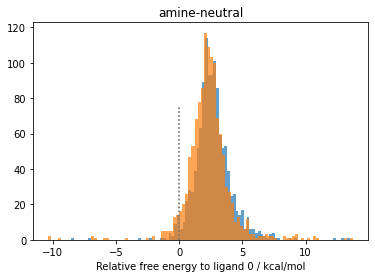

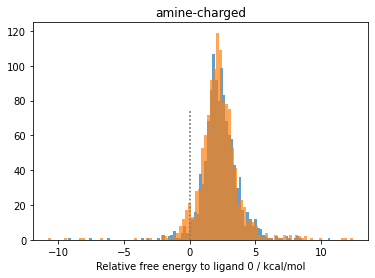

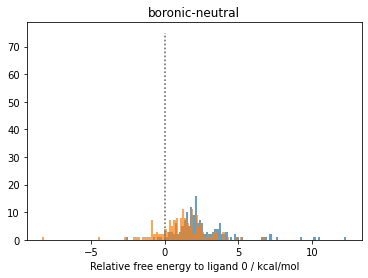

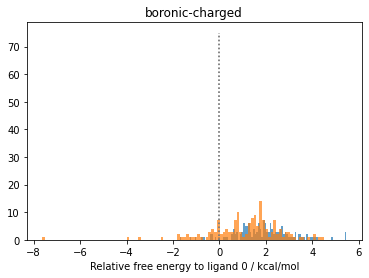

In [10]:
for results in r:
    plt.hist(r[results]['DDG_f'].values(),bins=100,alpha=0.7)
    plt.xlabel('Relative free energy to ligand 0 / kcal/mol')
    plt.vlines(0,0,75,'grey',linestyles=':')


    plt.hist(r[results]['DDG_r'].values(),bins=100,alpha=0.7)
    plt.xlabel('Relative free energy to ligand 0 / kcal/mol')
    plt.vlines(0,0,75,'grey',linestyles=':')
    plt.title(results)
    plt.show()

<Figure size 540x540 with 0 Axes>

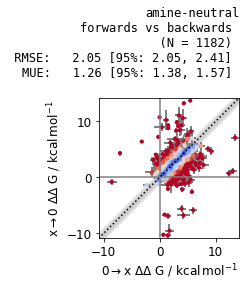

<Figure size 540x540 with 0 Axes>

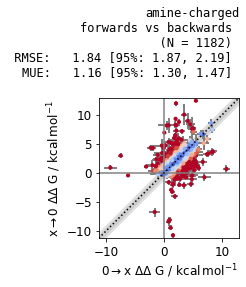

<Figure size 540x540 with 0 Axes>

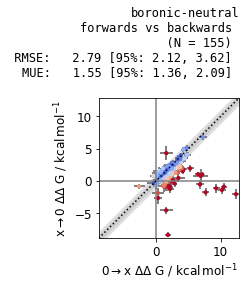

<Figure size 540x540 with 0 Axes>

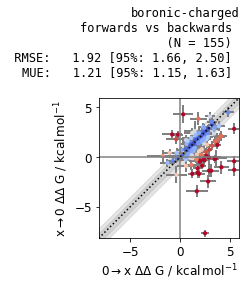

In [11]:
from beryllium import plotting
for results in r:
    xs = []
    ys = []
    x_err = []
    y_err = []
    plt.figure(figsize=(7.5,7.5))
    for lig in r[results]['DDG_f'].keys():
        if lig in r[results]['DDG_r']:
            xs.append(r[results]['DDG_f'][lig])
            ys.append(r[results]['DDG_r'][lig])
            x_err.append(r[results]['dDDG_f'][lig])
            y_err.append(r[results]['dDDG_r'][lig])
    plotting._master_plot(np.asarray(xs), np.asarray(ys),xerr=np.asarray(x_err), yerr=np.asarray(y_err),title=f"{results}\nforwards vs backwards", xlabel=r'0$\rightarrow$x', ylabel=r'x$\rightarrow$0')

    plt.show()

In [12]:
def _get_best_number(ligand_result, n=10):
    return sorted(ligand_result.items(), key=lambda kv: kv[1])[0:n]

def _get_best_percent(ligand_result, p=10):
    assert 0 < p < 100, f'Percentage must be between 0 and 100 %, percentage {p} not in range'
    n = int(len(ligand_result) * (p/100))
    return sorted(ligand_result.items(), key=lambda kv: kv[1])[0:n]

def _get_better_than(ligand_result, threshold=0):
    return [(k,v) for k,v in ligand_result.items() if v < threshold]

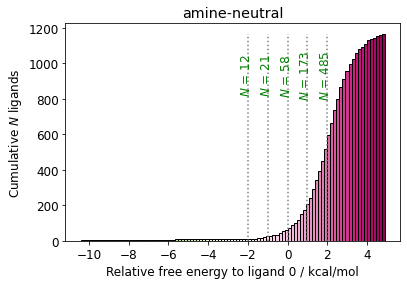

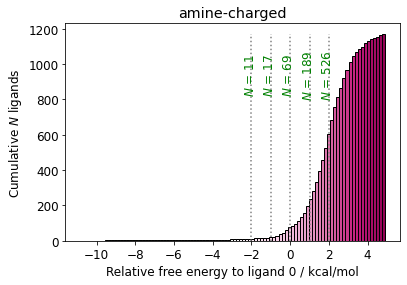

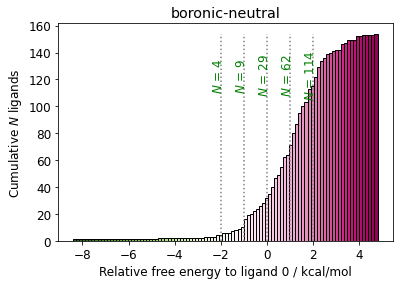

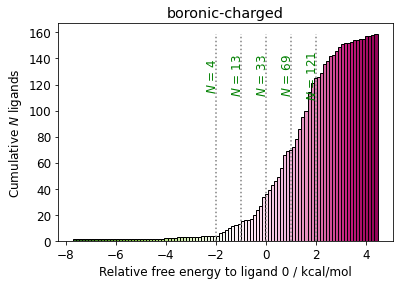

In [13]:
for results in r:
    ligand_result = r[results]['DDG_r']
    subset = {k:v for k,v in ligand_result.items() if v < 5}

    cm = plt.cm.get_cmap('PiYG')

    # Get the histogramp
    Y,X = np.histogram(list(subset.values()), 100)
    Y = np.cumsum(Y)
    # Y = np.log(Y)
    x_span = X.max()-X.min()
    C = [cm(((X.max()-x)/x_span)) for x in X]

    plt.bar(X[:-1],Y,color=C,width=X[1]-X[0],edgecolor='k')

    for v in range(-2,3):
        plt.vlines(-v,0,max(Y),'grey',linestyles=':')
        plt.text(v-0.4, 0.8*max(Y),f"$N$ = {len(_get_better_than(subset,v))}", rotation=90, verticalalignment='center',color='green')
    plt.xlabel('Relative free energy to ligand 0 / kcal/mol')
    plt.ylabel('Cumulative $N$ ligands')
    plt.title(results)
    plt.show()

In [14]:
import mdtraj as md

def _find_lowest_work(work, run, proj='13420',forward=True):
    filter_works = work[(work['PROJ']==f'PROJ{proj}')]
    filter_works = filter_works[(filter_works['RUN']==run)]
    if forward == True:
        lowest_work_df = filter_works[filter_works.reverse_work == filter_works.forward_work.min()]
    else:
        lowest_work_df = filter_works[filter_works.reverse_work == filter_works.reverse_work.min()]

    # TODO there is no way that there isn't a better way to do this with pandas
    clone = list(lowest_work_df['CLONE'])[0]
    gen = list(lowest_work_df['GEN'])[0]
    return clone[5:], gen[3:]

def get_structure(proj,RUNID,GEN,CLONE,filename='',forwards=True,n_atoms=None):  
    # frame 0 is start ligand after EQUIL
    # 0 -> 1 NEQ
    # frame 1 is end ligand after NEQ
    # frame 2 is end ligand after EQ
    # 1 -> 0 NEQ
    # frame 3 is start ligand after NEQ
    
    # TODO - still not 100% sure this is exactly what we want
    if forwards:
        frame = 3
    else:
        frame = 1
        
    os.system(f'scp server@aws3.foldingathome.org:/home/server/server2/projects/{proj}/RUNS/{RUNID}/*pdb {RUNID}.pdb')
    topology = md.load(f'{RUNID}.pdb').topology

    try:
        os.system(f'scp server@aws3.foldingathome.org:/home/server/server2/data/SVR314342810/PROJ{proj}/{RUNID}/CLONE{CLONE}/results{GEN}/*xtc pos_{RUNID}.xtc')
        traj = md.load_xtc(f'pos_{RUNID}.xtc',topology,frame=3)
    except ValueError:
        print(f'error for clone {CLONE} gen {GEN}')
        

    # find the atom indices for the ligand (resname 'MOL')
    if n_atoms is not None:  
        atoms = [i for i in range(topology.n_atoms)]
        mol_ids = []
        for res in topology.residues:
            if res.name == 'MOL':
                for atom in res.atoms:
                    if len(mol_ids) < n_atoms:
                        mol_ids.append(atom.index)
                    else:
                        atoms.remove(atom.index)
        traj.atom_slice(atoms, inplace=True)
    traj.image_molecules()
        
    traj.save_pdb(filename)
    
    # now doing cleanup
    os.system(f'rm {RUNID}.pdb')
    os.system(f'rm pos_{RUNID}.xtc')

In [15]:
### this will be useful for looking at looking at shift in relative FEs over GENS

for d in details.values():
#     print(d['complex_fes_GEN1'])
#     print(d['solvent_fes_GEN0'])
    if len(d['complex_fes_GEN1']) > 0 and len(d['solvent_fes_GEN1']) > 0: # only interesting with more than one GEN done
        for i in range(0,n_gens_run):
            try:
                DDG = ((np.mean(d[f'complex_fes_GEN{i}']) - np.mean(d[f'solvent_fes_GEN{i}']))*kT).value_in_unit(unit.kilocalories_per_mole) 
                dDDG = ((np.mean(d[f'complex_dfes_GEN{i}'])**0.5 + np.mean(d[f'solvent_dfes_GEN{i}'])**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
                plt.errorbar(i, DDG,yerr=dDDG)
                plt.scatter(i,DDG)
            except:
                continue
    plt.show()


Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): EN300-321459
Problematic atoms are:
Atom atomic num: 7, name: , idx: 23, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 18, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): EN300-321459
Problematic atoms are:
Atom atomic num: 7, name: , idx: 23, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 8, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic n

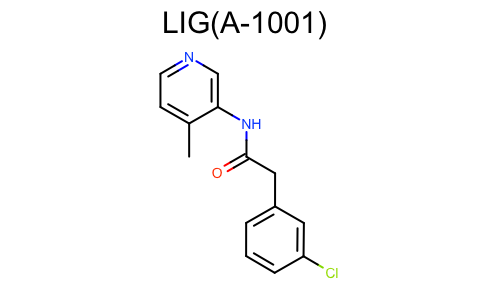

In [16]:
from openforcefield.topology import Molecule
molecules = Molecule.from_file('primary_amine_enumeration_for_chodera_lab_FEP-permuted-conformers.sdf',allow_undefined_stereo=True)
from rdkit.Chem.Draw import IPythonConsole
        
mol = molecules[0]
mol.visualize(backend='openeye')

In [17]:
n = 60

results = r['amine-neutral']
l = results['DDG_f']
best_amine_neutral_forwards = _get_best_number(l,n=n)
l = results['DDG_r']
best_amine_neutral_backwards = _get_best_number(l,n=n)

results = r['amine-charged']
l = results['DDG_f']
best_amine_charged_forwards = _get_best_number(l,n=n)
l = results['DDG_r']
best_amine_charged_backwards = _get_best_number(l,n=n)

In [21]:
#### TODO --- add ligand uncertainty into selection of 'best'

from collections import Counter
neutral_amine = Counter([i[0] for i in best_amine_neutral_forwards] + [i[0] for i in best_amine_neutral_backwards])
with open('best_amide_neutral.txt','w') as f:
    for i in neutral_amine:
        f.write(f'{molecules[i].name}\n')

charged_amine = Counter([i[0] for i in best_amine_charged_forwards] + [i[0] for i in best_amine_charged_backwards])
with open('best_amine_charged.txt','w') as f:
    for i in charged_amine:
        f.write(f'{molecules[i].name}\n')

all_amine = Counter([i[0] for i in best_amine_neutral_forwards] + [i[0] for i in best_amine_neutral_backwards]+[i[0] for i in best_amine_charged_forwards] + [i[0] for i in best_amine_charged_backwards])
with open('best_amine_comb.txt','w') as f:
    for i in all_amine:
        f.write(f'{molecules[i].name}, {all_amine[i]}\n')

In [22]:
for i,j in all_amine.items():
    if j == 4:
        print(i)

637


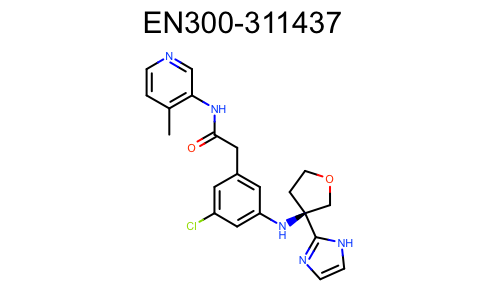

In [23]:
mol = molecules[637]
mol.visualize(backend='openeye')

In [24]:
from openeye import oedepict
from openeye import oechem

def make_image_with_ligs(ligands,molecules,filename):
    
    # this bit works out what size square the ligands can fit into
    n = len(ligands)
    sq = int(np.ceil(n**0.5)) # round up the square root of n_ligands
    
    
    image = oedepict.OEImage(sq*200, sq*200)

    rows, cols = sq,sq
    grid = oedepict.OEImageGrid(image, rows, cols)

    opts = oedepict.OE2DMolDisplayOptions(grid.GetCellWidth(), grid.GetCellHeight(),
                                           oedepict.OEScale_AutoScale)

    for (ind,fe), cell in zip(ligands, grid.GetCells()):
        mol = molecules[ind].to_openeye()
        mol.SetTitle(f'{mol.GetTitle()}\n{fe:.2f}')
        oedepict.OEPrepareDepiction(mol)
        disp = oedepict.OE2DMolDisplay(mol, opts)
        oedepict.OERenderMolecule(cell, disp)

    oedepict.OEWriteImage(filename, image)

make_image_with_ligs(best_amine_neutral_backwards,molecules,"BestNeutralBuchwald.pdf")
make_image_with_ligs(best_amine_charged_backwards,molecules,"BestChargedBuchwald.pdf")

In [28]:
ligand_indices = [i[0] for i in best_amine_neutral_backwards]
print(len(ligand_indices))
for d in details.values():
    # backwards, buchwald and not charged
    if d['start'] in ligand_indices and d['end'] == 0 and 'amine' in d['ligand'] and 'thiolate' not in d['protein']:
        print(d['directory'])
        mol = molecules[d['start']]
        clone, gen = _find_lowest_work(work,d['directory'],forward=False)
        get_structure(13420,d['directory'],gen,clone,filename=f'{mol.name}-neutral-buchwald.pdb',forwards=False,n_atoms=mol.n_atoms)        

60
RUN4668


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4692


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4693


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4700


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4701


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4763


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4787


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4834


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4851


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4865


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4868


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4871


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4908


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN4946


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5019


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5066


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5082


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5129


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5130


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5143


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5147


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5165


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5212


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5242


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5257


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5284


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5288


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5299


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5304


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5327


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5331


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5359


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5388


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5396


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5404


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5427


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5513


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5541


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5549


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5561


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5609


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5638


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5640


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5665


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5676


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5694


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5728


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5761


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5826


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5829


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5850


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5852


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5864


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5907


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5929


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5945


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5949


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5952


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN5981


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




In [ ]:
ligand_indices = [i[0] for i in best_amine_charged_backwards]
for d in details.values():
    # backwards, buchwald and charged
    if d['start'] in ligand_indices and d['end'] == 0 and 'amine' in d['ligand'] and 'thiolate' in d['protein']:
        print(d['directory'])
        mol = molecules[d['start']]
        clone, gen = _find_lowest_work(work,d['directory'],forward=False)
        get_structure(13420,d['directory'],gen,clone,filename=f'{mol.name}-charged-buchwald.pdb',forwards=False,n_atoms=mol.n_atoms)        

RUN5995


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6017


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6019


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6020


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6027


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6028


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6029


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6030


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6114


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6126


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6148


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6177


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6178


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6192


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6198


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6200


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6218


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6273


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6334


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6346


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6347


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6403


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




RUN6409


/Users/brucemah/miniconda3/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbstructure.py:435: UserWarning:




In [ ]:
# better_ligands = _get_better_than(ligand_result)
# plt.figure(figsize=(7.5,3))
# for i,(lig,val) in enumerate(sorted(ligand_result.items(), key=lambda kv: kv[1])):
#     if val-ligand_result_uncertainty[lig] < 0. < val+ligand_result_uncertainty[lig]:
#         plt.errorbar(i, val,yerr=ligand_result_uncertainty[lig],color='grey')
#     elif val+ligand_result_uncertainty[lig] < 0.:
#         plt.errorbar(i, val,yerr=ligand_result_uncertainty[lig],color='green')
#     else:
#         plt.errorbar(i, val,yerr=ligand_result_uncertainty[lig],color='red')
        
        
# plt.legendHandles[0].set_color('red')
# plt.legendHandles[1].set_color('yellow')
# plt.legend(['better','equal','worse'])
# plt.hlines(0,0,len(ligand_result),color='k',alpha=0.25)

# plt.show()

In [ ]:
from openforcefield.topology import Molecule
molecules = Molecule.from_file('../../covid-moonshot-new/synthetic-enumeration/boronic_ester_enumeration_for_chodera_lab_FEP-permuted-conformers-x10789.sdf',allow_undefined_stereo=True)
from rdkit.Chem.Draw import IPythonConsole
        
mol = molecules[0]
mol.visualize(backend='openeye')

In [ ]:
n = 36

results = r['boronic-neutral']
l = results['DDG_f']
best_boronic_neutral_forwards = _get_best_number(l,n=n)
l = results['DDG_r']
best_boronic_neutral_backwards = _get_best_number(l,n=n)

results = r['boronic-charged']
l = results['DDG_f']
best_boronic_charged_forwards = _get_best_number(l,n=n)
l = results['DDG_r']
best_boronic_charged_backwards = _get_best_number(l,n=n)

In [ ]:
#### TODO --- add ligand uncertainty into selection of 'best'

# from collections import Counter
# neutral_boronic = Counter([i[0] for i in best_boronic_neutral_backwards])
# with open('best_boronic_neutral.txt','w') as f:
#     for i in neutral_boronic:
#         f.write(f'{molecules[i].name}\n')

# charged_boronic = Counter([i[0] for i in best_boronic_charged_backwards])
# with open('best_boronic_charged.txt','w') as f:
#     for i in charged_boronic:
#         f.write(f'{molecules[i].name}\n')

# print(len(neutral_boronic))
        
# all_boronic = Counter([i[0] for i in best_boronic_neutral_backwards]+[i[0] for i in best_boronic_charged_forwards] + [i[0] for i in best_boronic_charged_backwards])
# with open('best_boronic_comb.txt','w') as f:
#     for i in all_boronic:
#         f.write(f'{molecules[i].name}, {all_amide[i]}\n')

In [ ]:
make_image_with_ligs(best_boronic_neutral_backwards,molecules,"BestNeutralSuzuki.pdf")
make_image_with_ligs(best_boronic_charged_backwards,molecules,"BestChargedSuzuki.pdf")

In [ ]:
mol = molecules[46]
mol.visualize(backend='openeye')

In [ ]:
ligand_indices = [i[0] for i in best_boronic_neutral_backwards]
for d in details.values():
    # backwards, suzuki and not charged
    if d['start'] in ligand_indices and d['end'] == 0 and 'boronic' in d['ligand'] and 'thiolate' not in d['protein']:
        print(d['directory'])
        mol = molecules[d['start']]
        clone, gen = _find_lowest_work(work,d['directory'],forward=False)
        get_structure(13420,d['directory'],gen,clone,filename=f'{mol.name}-neutral-suzuki.pdb',forwards=False,n_atoms=mol.n_atoms)


In [ ]:
ligand_indices = [i[0] for i in best_boronic_charged_backwards]
for d in details.values():
    # backwards, suzuki and not charged
    if d['start'] in ligand_indices and d['end'] == 0 and 'boronic' in d['ligand'] and 'thiolate' in d['protein']:
        print(d['directory'])
        mol = molecules[d['start']]
        clone, gen = _find_lowest_work(work,d['directory'],forward=False)
        get_structure(13420,d['directory'],gen,clone,filename=f'{mol.name}-charged-suzuki.pdb',forwards=False,n_atoms=mol.n_atoms)        